In [199]:
import numpy as np
import tensorflow as tf 
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist


<h3>Problem 1</h3>
<p>Things I needed to implment for deep learing:</p>
<ol>
<li>I had to initilizew weights and baises</li>
<li>I have to perform initlize the nodes of each hidden layer of the network</li>
<li>I performed forward propagation for each layer</li>
<li>I had to implement an activation function and applied it on the output of each layer</li>
<li>I had to implement a loss function</li>
<li>I had to implement back propagaiton method for the network</li>
<li>I had to train the model using a fit  method</li>
<li>I had to implement an optimizer to update the values of weights and baises</li>
<li>I had to implement a predict method</li>
</ol>

<h3>Problem 2</h3>

<p>&emsp;The sample code is a deep learning logistic regression model implemented using tensor flow version 1. The model is trained to learn to distinguish between species of flowers, specifically iris flowers of the <b><i>versicolor and virginica </i></b> class.<br/>
&emsp; The sample code begins by performing feature selection and data processing on the iris dataset, followed by the definition of the mini batch class. Further down, the paramters for the layers in the class were initilized and assigned values. The exmaple_net function defines the forward propagation operation for the network. Loss_op, train_op, optimizer, and accuracy are used to calculate the loss, forward, backward propagation, and accuracy of the model respectively. <br/>
&emsp; TensorFlow version one by default using graph computation, therefore a session has to be created for the training of the model. This session was created using the tf.session method. Within this session, the model is trained. 

</p>

In [200]:
class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [201]:
iris = load_iris()
features = iris["data"]
target = iris["target"]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

x_train, y_train, x_test, y_test = x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)
y_train = y_train.reshape(-1, 1)
onv = OneHotEncoder(sparse_output=False)
y_train = onv.fit_transform(y_train)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)


<h3>Problem 3</h3>

In [202]:


# network parameters


class Layer(tf.Module):
    def __init__(self, n_input, n_output, activation=None, name=None):
        super().__init__(name=name)
        self.weight = tf.Variable(tf.random.normal([n_input, n_output]))
        self.bais = tf.Variable(tf.random.normal([n_output]))
        self.activation = activation
    
    def __call__(self, x):
        y = tf.add(tf.matmul(x, self.weight), self.bais)
        if self.activation == None:
            return y
        return self.activation(y)


class LogisticRegression:
    def __init__(self, n_input = 4, n_classes=3,  lr=0.01, epoch=100, batch_size = 20):
        self.lr = lr
        self.epoch = epoch
        self.batch = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputlayer = Layer(n_input, 100, tf.nn.relu, "InputLayer")
        self.hidden1 = Layer(100, 50, tf.nn.relu, "hidden1")
        self.output = Layer(50,n_classes , name="outputLayer")
    
    #@tf.function
    def forward(self, x):
        logit = self.inputlayer(x)
        logit = self.hidden1(logit)
        logit = self.output(logit)

        return logit
    
    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train
        for i in range(self.epoch):
            total_loss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, self.batch):
                with tf.GradientTape() as tape:
                    logit = self.forward(mini_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mini_y, logit))
                
                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
                total_loss+= loss
            total_loss/=self.batch
            
            with tf.GradientTape() as tape:
                logit = self.forward(x_val)
                loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val, logit))
            accuracy = accuracy_score(np.argmax(y_train, 1), self.predict(x_train))
            gradient = tape.gradient(loss_val, tape.watched_variables())
            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
            
            print(f"Num epoch: {i} loss: {total_loss}: loss_val: {loss_val} accuracy: {accuracy}")
        return self
    
    def predict(self, x):
        y = tf.nn.softmax(self.forward(x)).numpy()

        return np.argmax(y, 1)
        
                
def accuracy_score(y_true, pred):
    correct = np.sum(np.round(y_true) == np.round(pred))
    total = y_true.shape[0]
    return correct/total



In [203]:
model = LogisticRegression()
model.fit(x_train, y_train, x_val, y_val)

Num epoch: 0 loss: 64.81022644042969: loss_val: 141.96441650390625 accuracy: 0.3333333333333333
Num epoch: 1 loss: 13.095169067382812: loss_val: 60.31312942504883 accuracy: 0.6666666666666666
Num epoch: 2 loss: 12.731282234191895: loss_val: 45.04583740234375 accuracy: 0.6666666666666666
Num epoch: 3 loss: 3.5586624145507812: loss_val: 13.4235200881958 accuracy: 0.6666666666666666
Num epoch: 4 loss: 1.2941588163375854: loss_val: 7.449328899383545 accuracy: 0.75
Num epoch: 5 loss: 0.7769892811775208: loss_val: 2.720351457595825 accuracy: 0.7916666666666666
Num epoch: 6 loss: 0.5563865303993225: loss_val: 0.4177115857601166 accuracy: 0.9375
Num epoch: 7 loss: 0.3524097502231598: loss_val: 0.18677596747875214 accuracy: 0.9583333333333334
Num epoch: 8 loss: 0.2015172690153122: loss_val: 0.37634268403053284 accuracy: 0.9166666666666666
Num epoch: 9 loss: 0.22352543473243713: loss_val: 0.46376073360443115 accuracy: 0.9479166666666666
Num epoch: 10 loss: 0.17282110452651978: loss_val: 0.550562

In [204]:
pred = model.predict(x_test)

accuracy_score(y_test, pred)

0.9666666666666667

Text(0, 0.5, 'True value')

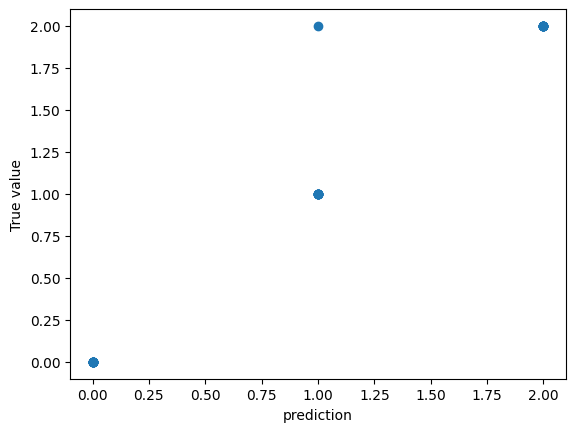

In [205]:
plt.scatter(pred, y_test)
plt.xlabel("prediction")
plt.ylabel("True value")

<h3>Problem 4</h3>

In [206]:
house_train = pd.read_csv("./data/train.csv")

<Axes: ylabel='SalePrice'>

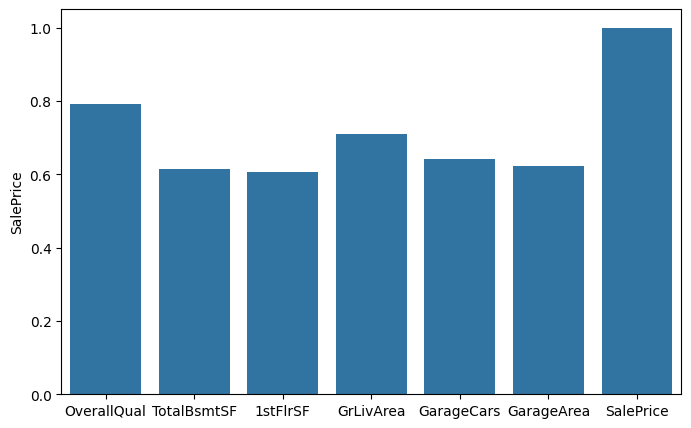

In [207]:
import seaborn as sns

test = house_train.dropna(axis=1).corr(numeric_only=True)
test = test["SalePrice"]
test = test[test > 0.6]

plt.figure(figsize=(8, 5))
sns.barplot(test)

In [208]:
def standardScaler(x):# standardization
    num = x - np.mean(x)
    return num/np.std(x)

def normalization(x):
    num = x - np.min(x)
    denum = np.max(x) - np.min(x)
    return num/denum

features = ["OverallQual","GrLivArea", "YearBuilt"]
target = ["SalePrice"]

y = house_train[target]
x = house_train[features]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# standardization of data
#x_train = x.apply(standardScaler).to_numpy().astype(np.float32)
#y_train = y.apply(standardScaler).to_numpy().astype(np.float32)

x_train = x.to_numpy().astype(np.float32)
y_train = y.to_numpy().astype(np.float32)

# normalization
# x_train = x.apply(normalization).to_numpy().astype(np.float32)
# y_train = y.apply(normalization).to_numpy().astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

x_test, y_test = x_test.to_numpy().astype(np.float32), y_test.to_numpy().astype(np.float32)

In [209]:
class LinearRegression:
    def __init__(self, n_input=3, lr=0.001, epoch= 100, batch_size=20):
        self.lr = lr
        self.batch_size = batch_size
        self.epoch = epoch
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputLayer = Layer(n_input, 200, name= "inputLayer")
        self.middleLayer1 = Layer(200, 100, name="middleLayer")
        self.middleLayer = Layer(100, 50, name="middleLayer")
        self.outputLayer = Layer(50, 1, name="outputLayer")
        self.loss = np.array([])
    
    def forward(self, x):
        logit = self.inputLayer(x)
        logit = self.middleLayer1(logit)
        logit = self.middleLayer(logit)
        logit = self.outputLayer(logit)

        return logit

    def predict(self, x):
        return self.forward(x)
    
    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train

        for i in range(self.epoch):
            totalLoss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, batch_size= self.batch_size):
                with tf.GradientTape() as tape:
                    y = self.forward(mini_x)
                    #MSE loss function
                    loss = tf.reduce_mean(tf.pow(y - mini_y, 2))
                    totalLoss += loss 
                
                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            totalLoss/=self.batch_size
            self.loss = np.append(self.loss, totalLoss)

            with tf.GradientTape() as tape:
                y = self.forward(x_val)
                
                loss_val = tf.reduce_mean(tf.pow(y-y_val, 2))
            
            gradient = tape.gradient(loss_val, y)

            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
            accuracy = accuracy_score(y_val, self.predict(x_val))

            print(f"Epoch: {i} loss: {totalLoss} Loss_val: {loss_val}")
        
        return self

        


        
        


In [210]:
linearModel = LinearRegression(epoch=100, lr=1e-5)

linearModel.fit(x_train, y_train, x_val, y_val)

Epoch: 0 loss: 5457230954496.0 Loss_val: 1504527122432.0
Epoch: 1 loss: 3920153804800.0 Loss_val: 1059704799232.0
Epoch: 2 loss: 2794886266880.0 Loss_val: 741867388928.0
Epoch: 3 loss: 2003562790912.0 Loss_val: 523630346240.0
Epoch: 4 loss: 1467822374912.0 Loss_val: 379530477568.0
Epoch: 5 loss: 1117466132480.0 Loss_val: 287623479296.0
Epoch: 6 loss: 894055612416.0 Loss_val: 230318931968.0
Epoch: 7 loss: 752436707328.0 Loss_val: 194567864320.0
Epoch: 8 loss: 660370751488.0 Loss_val: 171439325184.0
Epoch: 9 loss: 596639875072.0 Loss_val: 155301609472.0
Epoch: 10 loss: 548360224768.0 Loss_val: 142877278208.0
Epoch: 11 loss: 508309536768.0 Loss_val: 132401856512.0
Epoch: 12 loss: 472737972224.0 Loss_val: 122994188288.0
Epoch: 13 loss: 439841521664.0 Loss_val: 114244837376.0
Epoch: 14 loss: 408813600768.0 Loss_val: 105978208256.0
Epoch: 15 loss: 379324694528.0 Loss_val: 98124283904.0
Epoch: 16 loss: 351250612224.0 Loss_val: 90657538048.0
Epoch: 17 loss: 324550557696.0 Loss_val: 83569475584

Text(0, 0.5, 'true value')

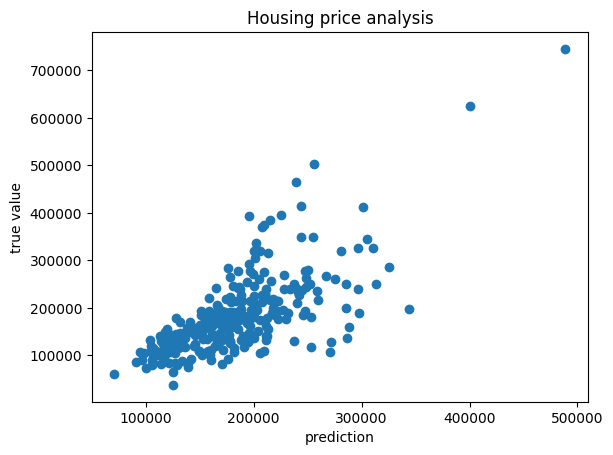

In [211]:
pred = linearModel.predict(x_test)

plt.scatter(pred, y_test)
plt.title("Housing price analysis")
plt.xlabel("prediction")
plt.ylabel("true value")

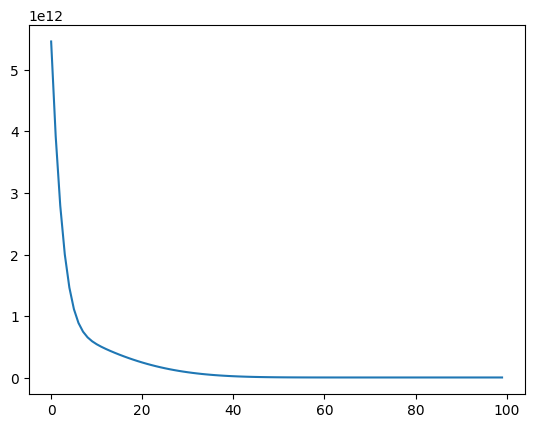

In [212]:
plt.plot(linearModel.loss)

<h3>Problem 5</h3>

In [213]:
class DeepNeuralNetwork:
    def __init__(self, n_input = 4, n_classes=3,  lr=0.01, epoch=100, batch_size = 20):
        self.lr = lr
        self.epoch = epoch
        self.batch = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputlayer = Layer(n_input, 400, tf.nn.relu, "InputLayer")
        self.hidden1 = Layer(400, 200, tf.nn.relu, "hidden1")
        self.output = Layer(200, n_classes, name="outputLayer")
    
    #@tf.function
    def forward(self, x):
        logit = self.inputlayer(x)
        logit = self.hidden1(logit)
        logit = self.output(logit)

        return logit
    
    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train
        for i in range(self.epoch):
            total_loss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, self.batch):
                with tf.GradientTape() as tape:
                    logit = self.forward(mini_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mini_y, logit))
                
                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
                total_loss+= loss
            total_loss/=self.batch
            
            with tf.GradientTape() as tape:
                logit = self.forward(x_val)
                loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val, logit))
            accuracy = accuracy_score(np.argmax(y_train, 1), self.predict(x_train))
            gradient = tape.gradient(loss_val, tape.watched_variables())
            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
            
            print(f"Num epoch: {i} loss: {total_loss}: loss_val: {loss_val} accuracy: {accuracy}")
        return self
    
    def predict(self, x):
        y = tf.nn.softmax(self.forward(x)).numpy()

        return np.argmax(y, 1)
        
                
def accuracy_score(y_true, pred):
    correct = np.sum(np.round(y_true) == np.round(pred))
    total = y_true.shape[0]
    return correct/total

In [220]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)
x_train, x_test = x_train.reshape(-1, 784).astype(np.float32), x_train.reshape(-1, 784).astype(np.float32)

x_train /= 255
x_test /= 255

y_train, y_test = onv.fit_transform(y_train), onv.fit_transform(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [218]:
x_train.shape
#y_train.shape
n_input = x_train.shape[1]
n_classes = y_train.shape[1]

In [221]:
model = DeepNeuralNetwork(lr=0.001, n_input=n_input, n_classes=n_classes, epoch=10).fit(x_train, y_train, x_val, y_val)